In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn import preprocessing

from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

import warnings
warnings.filterwarnings('ignore')

In [ ]:
"""Load DataFrame"""
df=pd.read_csv('/content/drive/MyDrive/vehicles.csv')
df=pd.DataFrame(df)
df.head()

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
0,7222695916,https://prescott.craigslist.org/cto/d/prescott...,prescott,https://prescott.craigslist.org,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN,NaN
1,7218891961,https://fayar.craigslist.org/ctd/d/bentonville...,fayetteville,https://fayar.craigslist.org,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN,NaN,NaN
2,7221797935,https://keys.craigslist.org/cto/d/summerland-k...,florida keys,https://keys.craigslist.org,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN,NaN,NaN
3,7222270760,https://worcester.craigslist.org/cto/d/west-br...,worcester / central MA,https://worcester.craigslist.org,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN,NaN,NaN
4,7210384030,https://greensboro.craigslist.org/cto/d/trinit...,greensboro,https://greensboro.craigslist.org,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN,NaN,NaN


In [ ]:
"""Reindexing DataFrame so that price feature will at last"""
df= df.reindex(columns=['id', 'url', 'region', 'region_url', 'year', 'manufacturer',
       'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status',
       'transmission', 'vin', 'drive', 'size', 'type', 'paint_color',
       'image_url', 'description', 'county', 'state', 'lat', 'long','price'])

In [ ]:
df2=df.copy()
df2=df2.drop(columns=['url','region_url','vin','image_url','description','county','state'])
df2.head()


,id,region,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,lat,long,price
0,7222695916,prescott,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6000
1,7218891961,fayetteville,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11900
2,7221797935,florida keys,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21000
3,7222270760,worcester / central MA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1500
4,7210384030,greensboro,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4900


In [ ]:
df2.isnull().sum() #return series of columns with respective of number of null values

id                   0
region               0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
drive           130567
size            306361
type             92858
paint_color     130203
lat               6549
long              6549
price                0
dtype: int64

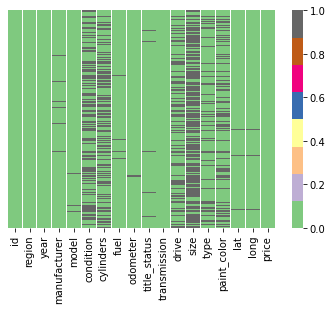

In [ ]:
sns.heatmap(df2.isnull(),yticklabels=False,cbar=True,cmap='Accent')


In [ ]:
#define numeric variable and categorical variable to work separatly on them
num_col=['year','odometer','lat','long']
cat_cols=['region','manufacturer','model','condition','cylinders','fuel','title_status','transmission','drive','size','type','paint_color']

# 2.1) Estimating better iterative imputer method

In [ ]:
check_imputer=df2.copy()
check_imputer=check_imputer.drop(columns=['id'])

#object of LabelEncoder
encoder=preprocessing.LabelEncoder()

#function to label the categorical columns ignoring null values 
def encode(data):
    #retains only non-null values
    nonulls = np.array(data.dropna())
    #reshapes the data for encoding
    impute_reshape = nonulls.reshape(-1,1)
    #encode date
    impute_ordinal = encoder.fit_transform(impute_reshape)
    #Assign back encoded values to non-null values
    data.loc[data.notnull()] = np.squeeze(impute_ordinal)
    return data

#loop to label each column or categorical values into numberic
for i in tqdm(range(len(cat_cols))):
    encode(check_imputer[cat_cols[i]])

100%|██████████| 12/12 [00:01<00:00,  6.48it/s]


In [ ]:
check_imputer.head()


,region,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,lat,long,price
0,277,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6000
1,105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11900
2,111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21000
3,396,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1500
4,131,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4900


In [ ]:
# Estimate the score on the entire dataset by filling missing values by mean and median

br_estimator = BayesianRidge() #base estimator
N_SPLITS = 6  #defining the cross-validation splitting strategy

score_simple_imputer = pd.DataFrame() #dataframe to store error of imputer
#computing MSE for mean and median
for strategy in ('mean', 'median'):
    X=check_imputer.iloc[:,:-1]
        #y=check_imputer.iloc[:,-1:].values.ravel()
    y = np.ravel(check_imputer.iloc[:,-1:])
    estimator = make_pipeline(
        SimpleImputer(missing_values=np.nan, strategy=strategy),
        br_estimator
    )
    score_simple_imputer[strategy] = cross_val_score(
        estimator, X, y, scoring='neg_mean_squared_error',
        cv=N_SPLITS
    )

In [ ]:
# Estimate the score on the entire dataset by filling missing values by 3 different iterative imputer


#estimators for IterativeImputer
estimators = [
    BayesianRidge(),
    DecisionTreeRegressor(max_features='sqrt', random_state=0),
    ExtraTreesRegressor(n_estimators=10, random_state=0),
    
]
score_iterative_imputer = pd.DataFrame()
for esti in estimators:
        print("Estimating",esti.__class__.__name__)
        imputer = IterativeImputer(esti)
        df_new=check_imputer.copy()
        for col in check_imputer.columns:
            #col=check_imputer.columns[i]
            impute_data=imputer.fit_transform(df_new[col].values.reshape(-1,1))
            impute_data=impute_data.astype('int64')
            impute_data = pd.DataFrame(np.ravel(impute_data))
            df_new[col]=impute_data
        X=df_new.iloc[:,:-1]
        #y=check_imputer.iloc[:,-1:].values.ravel()
        y = np.ravel(df_new.iloc[:,-1:])
        score_iterative_imputer[esti.__class__.__name__] = cross_val_score(esti,X,y,scoring='neg_mean_squared_error',cv=6)

Estimating BayesianRidge
Estimating DecisionTreeRegressor
Estimating ExtraTreesRegressor


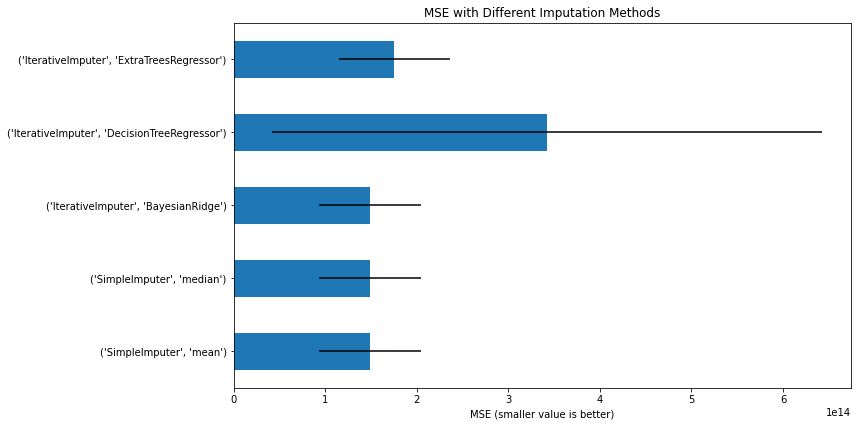

In [ ]:
#ploting the graphs of scores each method
scores = pd.concat(
    [score_simple_imputer, score_iterative_imputer],
    keys=['SimpleImputer', 'IterativeImputer'], axis=1
)
fig, ax = plt.subplots(figsize=(12, 6))
means = -scores.mean()
errors = scores.std()
means.plot.barh(xerr=errors, ax=ax)
ax.set_title('MSE with Different Imputation Methods')
ax.set_xlabel('MSE (smaller value is better)')
ax.set_yticks(np.arange(means.shape[0]))
ax.set_yticklabels(means.index.tolist())
plt.tight_layout(pad=1)
plt.savefig('different-imputations-method',dpi=None)
plt.show()

In [ ]:
df2.isnull().sum()[num_col]


year        1205
odometer    4400
lat         6549
long        6549
dtype: int64

In [ ]:
data_num=df2[num_col]
imputer_num=IterativeImputer(estimators[1]) #estimators[1] = BayesianRidge
impute_data=imputer_num.fit_transform(data_num)
df2[num_col]=impute_data

In [ ]:
#Missing values after filling
df2.isnull().sum()[num_col]

year        0
odometer    0
lat         0
long        0
dtype: int64

In [ ]:
#Missing values before filling
df2.isnull().sum()[cat_cols]

region               0
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
title_status      8242
transmission      2556
drive           130567
size            306361
type             92858
paint_color     130203
dtype: int64

In [ ]:
data_cat=df2[cat_cols]
encoder=preprocessing.LabelEncoder()

#create a for loop to iterate through each column in the data
for columns in cat_cols:
    encode(data_cat[columns])
    imputer = IterativeImputer(BayesianRidge())
    impute_data=imputer.fit_transform(data_cat[columns].values.reshape(-1, 1))
    impute_data=impute_data.astype('int64')
    impute_data = pd.DataFrame(impute_data)
    impute_data =encoder.inverse_transform(impute_data.values.reshape(-1, 1))
    data_cat[columns]=impute_data
df2[cat_cols]=data_cat    

In [ ]:
#Missing values after filling
df2.isnull().sum()[cat_cols]

region          0
manufacturer    0
model           0
condition       0
cylinders       0
fuel            0
title_status    0
transmission    0
drive           0
size            0
type            0
paint_color     0
dtype: int64

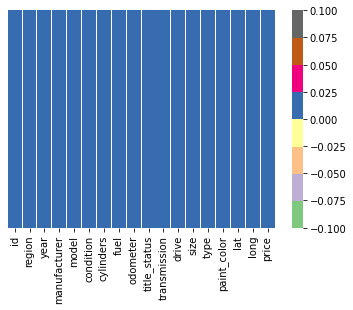

In [ ]:
#Heat map tp check numm values visually
sns.heatmap(df2.isnull(),yticklabels=False,cbar=True,cmap='Accent')

In [ ]:
#No null value in the dataset 
df2.isnull().sum()

id              0
region          0
year            0
manufacturer    0
model           0
condition       0
cylinders       0
fuel            0
odometer        0
title_status    0
transmission    0
drive           0
size            0
type            0
paint_color     0
lat             0
long            0
price           0
dtype: int64

In [ ]:
df2.to_csv('vehiclesData.csv',index=False)

#outliners


In [ ]:
from IPython.display import display,Latex
outliers_condi=Latex(r" $\textbf{W𝑒 𝑐𝑎𝑛 𝑠𝑎𝑦 $𝑥_1$ or $x_2$ 𝑖𝑠 𝑜𝑢𝑡𝑙𝑖𝑒𝑟𝑠 if }\\ x_1 < Q1 - 1.5*IQR \\ or\\ x_2 > Q3+1.5*IQR $")
outliers_info=Latex(r"$L_{p} = \frac{p}{100}(n+1) = i_p.f_p \\ where \,\, i_p \,\, is \,\, integer \,\, part \,\, of \,\, L_p \,\, and \,\, f_p \,\, is \,\, fractional \,\, part \,\, of \,\, L_p \\ Q1 = Y_{25} = x_{i_p} + f_p*(x_{i_{p+1}}-x_{i_p}) \\ Q3 = Y_{75} = x_{i_p} + f_p*(x_{i_{p+1}}-x_{i_p}) \\ IQR = Q3-Q1 \\ x_1 = Q1 - 1.5*IQR \,\,and\,\, x_2 = Q3+1.5*IQR $")

In [ ]:
display(outliers_info)
display(outliers_condi)


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [ ]:
#it will return the range of the variables and the values outside this range will be outliers
def outliers(arr,col):
    x=sorted(arr[col].values.ravel())
    L_25=25/100*(len(x)+1) #L_p where p=25%
    i_p=int(str(L_25).split(".")[0])
    f_p=int(str(L_25).split(".")[1])
    q1=x[i_p]+f_p*(x[i_p+1]-x[i_p])
    
    L_75=75/100*(len(x)+1) #L_p where p=75%
    i_p=int(str(L_75).split(".")[0])
    f_p=int(str(L_75).split(".")[1])
    q3=x[i_p]+f_p*(x[i_p+1]-x[i_p])
    
    #q1,q3=(arr[col].quantile([0.25,0.75]))
    
    IQR=q3-q1
    x1=q1-1.5*IQR
    x2=q3+1.5*IQR
    return (x1,x2)

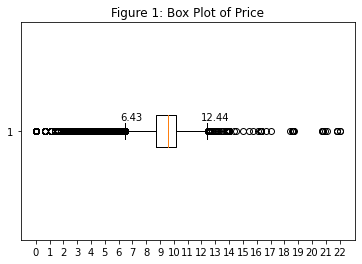

In [ ]:
def min_max_price(df):
    r=[]
    q1,q3=(df['logprice'].quantile([0.25,0.75]))
    r.append(q1-1.5*(q3-q1))
    r.append(q3+1.5*(q3-q1))
    return (r)
df2['logprice'] = np.log(df2['price'])
x=df2['logprice']
price_range=list(range(0,int(max(df2['logprice']))+1))
red_square = dict(markerfacecolor='g', marker='s')
plt.boxplot(x, vert=False)
plt.xticks(price_range)
plt.text(min_max_price(df2)[0]-0.3,1.05,str(round(min_max_price(df2)[0],2)))
plt.text(min_max_price(df2)[1]-0.5,1.05,str(round(min_max_price(df2)[1],2)))
plt.title("Figure 1: Box Plot of Price")
plt.savefig('graph-boxplot-price.jpg')
plt.show()

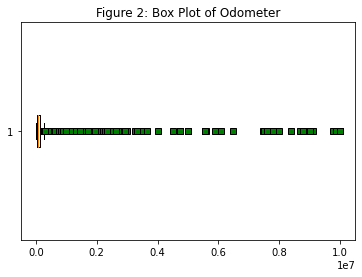

In [ ]:
fig, ax1 = plt.subplots()
ax1.set_title('Figure 2: Box Plot of Odometer')
ax1.boxplot(df2['odometer'], vert=False, flierprops=red_square)
plt.savefig('graph-boxplot-odometer.jpg')
plt.show()

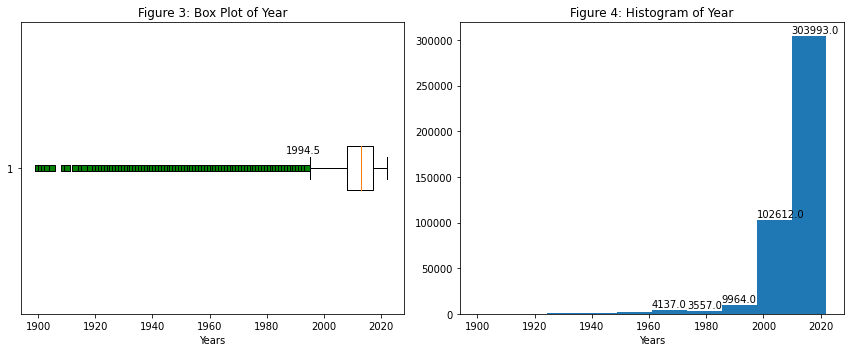

In [ ]:
fig,(ax1,ax2)=plt.subplots(ncols=2,figsize=(12,5))

#ploting boxplot
o1,o2=outliers(df2,'year')
ax1.boxplot(sorted(df2['year']), vert=False, flierprops=red_square)
ax1.set_xlabel("Years")
ax1.set_title("Figure 3: Box Plot of Year")
ax1.text(o1-8,1.05,str(round(o1,2)))

#ploting histogram
hist,bins=np.histogram(df2['year'])
n, bins, patches = ax2.hist(x=df2['year'], bins=bins)
ax2.set_xlabel("Years")
ax2.set_title("Figure 4: Histogram of Year")
for i in range(len(n)):
    if(n[i]>2000):
        ax2.text(bins[i],n[i]+3000,str(n[i]))

plt.tight_layout()
plt.savefig('graph-barplot-histogram-year.jpg',dpi=1200)
plt.show()

In [ ]:
#removing outliers 
df_new=df2.copy()
out=np.array(['logprice','odometer','year'])
for col in out:
    o1,o2=outliers(df_new,col)
    df_new=df_new[(df_new[col]>=o1) & (df_new[col]<=o2)]
    print('IQR of',col,'=',o1,o2)
df_new=df_new[df_new['price']!=0]
df_new.drop('logprice',axis=1,inplace=True)

IQR of logprice = 6.430098455893903 12.43705625322699
IQR of odometer = -108476.0 282956.0
IQR of year = 1994.5 2030.5


In [ ]:
df_new.head()

,id,region,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,lat,long,price
0,7222695916,prescott,2009.0,infiniti,g series,fair,5 cylinders,gas,167000.0,clean,automatic,4wd,full-size,offroad,grey,40.4109,-74.238,6000
1,7218891961,fayetteville,2009.0,infiniti,g series,fair,5 cylinders,gas,167000.0,clean,automatic,4wd,full-size,offroad,grey,40.4109,-74.238,11900
2,7221797935,florida keys,2009.0,infiniti,g series,fair,5 cylinders,gas,167000.0,clean,automatic,4wd,full-size,offroad,grey,40.4109,-74.238,21000
3,7222270760,worcester / central MA,2009.0,infiniti,g series,fair,5 cylinders,gas,167000.0,clean,automatic,4wd,full-size,offroad,grey,40.4109,-74.238,1500
4,7210384030,greensboro,2009.0,infiniti,g series,fair,5 cylinders,gas,167000.0,clean,automatic,4wd,full-size,offroad,grey,40.4109,-74.238,4900


In [ ]:
print("Shape before process=",df.shape)
print("Shape After process=",df_new.shape)
diff=df.shape[0]-df_new.shape[0]
print("Total {} rows and {} cols removed".format(diff,df.shape[1]-df_new.shape[1]))
df_new.to_csv("vehiclesFinal.csv",index=False)

Shape before process= (426880, 25)
Shape After process= (364373, 18)
Total 62507 rows and 7 cols removed


#visualization

In [ ]:
df=pd.read_csv("vehiclesFinal.csv")
df['year']=df['year'].astype('int64')
df.drop(['lat','long','id'],axis=1,inplace=True)
df.head()


,region,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,price
0,prescott,2009,infiniti,g series,fair,5 cylinders,gas,167000.0,clean,automatic,4wd,full-size,offroad,grey,6000
1,fayetteville,2009,infiniti,g series,fair,5 cylinders,gas,167000.0,clean,automatic,4wd,full-size,offroad,grey,11900
2,florida keys,2009,infiniti,g series,fair,5 cylinders,gas,167000.0,clean,automatic,4wd,full-size,offroad,grey,21000
3,worcester / central MA,2009,infiniti,g series,fair,5 cylinders,gas,167000.0,clean,automatic,4wd,full-size,offroad,grey,1500
4,greensboro,2009,infiniti,g series,fair,5 cylinders,gas,167000.0,clean,automatic,4wd,full-size,offroad,grey,4900


In [ ]:
df.shape


(364373, 15)

In [ ]:
df.columns


Index(['region', 'year', 'manufacturer', 'model', 'condition', 'cylinders',
       'fuel', 'odometer', 'title_status', 'transmission', 'drive', 'size',
       'type', 'paint_color', 'price'],
      dtype='object')

In [ ]:
df2=df.sample(100)
df2.shape

(100, 15)

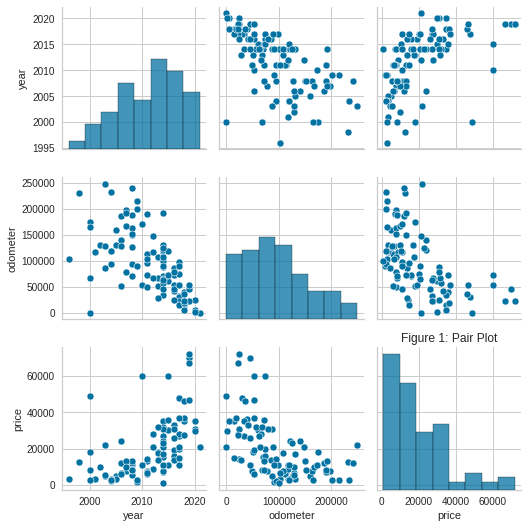

In [ ]:
sns.pairplot(df2)
plt.title('Figure 1: Pair Plot')
plt.tight_layout()
plt.savefig('Insight-Pair-Plot',dpi=None)
plt.show()

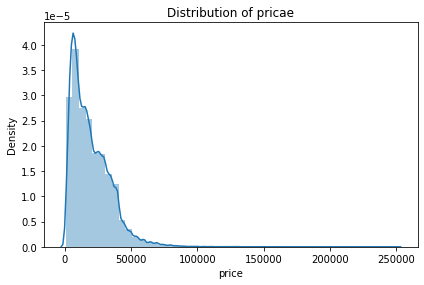

In [ ]:
sns.distplot(df.price)
plt.tight_layout()
plt.title("Distribution of pricae")
plt.savefig('Insight-Dist-Plot',dpi=None)
plt.show()

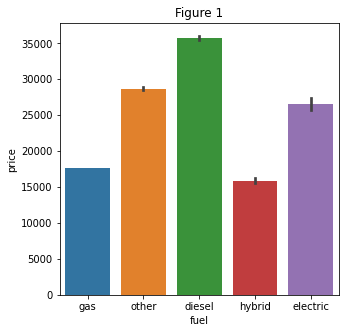

In [ ]:
fig,axs=plt.subplots()
fig.set_size_inches(5,5)

p1=sns.barplot(x='fuel',y='price',data=df,ax=axs)
axs.set_title('Figure 1')

plt.savefig('Insight-Figure-1',dpi=None)
plt.show()

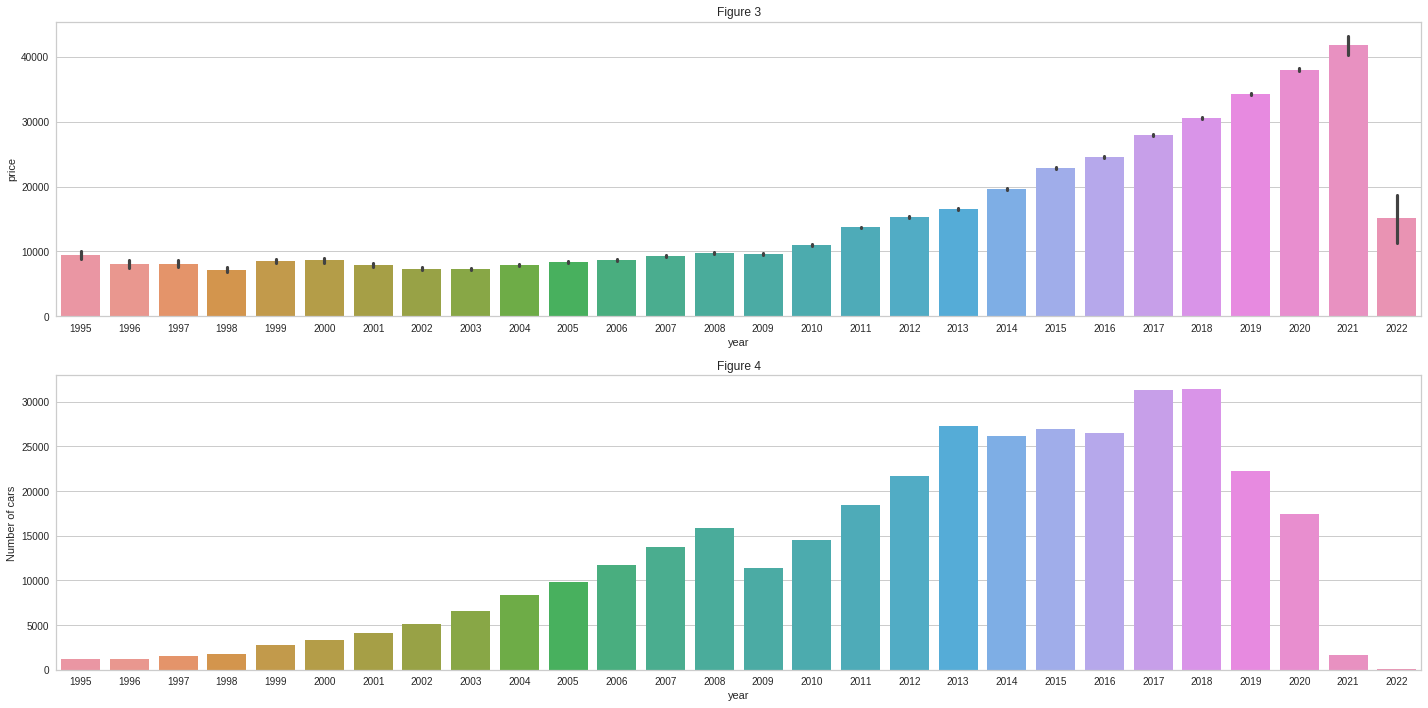

In [ ]:
fig,axs=plt.subplots(nrows=2)
fig.set_size_inches(20,10)
sns.barplot(x='year',y='price',data=df,ax=axs[0])
sns.barplot(df.groupby('year').count()['price'].index,df.groupby('year').count()['price'].values,ax=axs[1])
axs[0].set_title('Figure 3')
axs[1].set_title('Figure 4')
axs[1].set_ylabel('Number of cars')
plt.tight_layout()
plt.savefig('Insight-Figure-3-4.jpg',dpi=50)
plt.show()

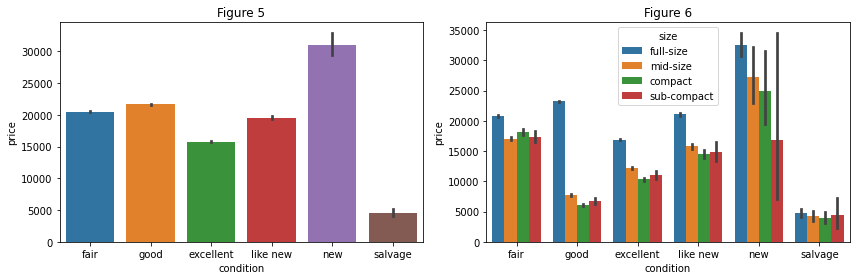

In [ ]:
fig,axs=plt.subplots(ncols=2)
fig.set_size_inches(12,4)
sns.barplot(x='condition',y='price',data=df,ax=axs[0])
sns.barplot(x='condition',y='price',hue='size',data=df,ax=axs[1])
axs[0].set_title('Figure 5')
axs[1].set_title('Figure 6')
plt.tight_layout()
plt.savefig('Insight-Figure-5-6.jpg',dpi=600)
plt.show()

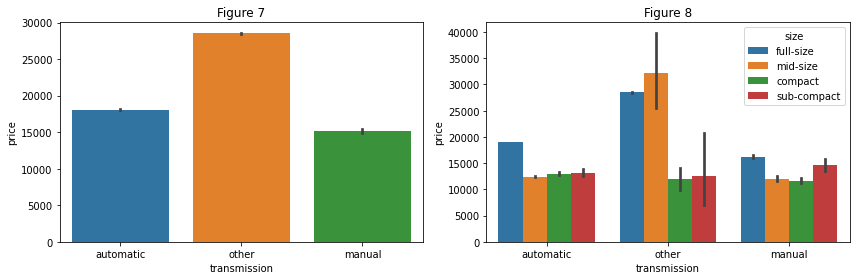

In [ ]:
fig,axs=plt.subplots(ncols=2)
fig.set_size_inches(12,4)
sns.barplot(x='transmission',y='price',data=df,ax=axs[0])
sns.barplot(x='transmission',y='price',hue='size',data=df,ax=axs[1])
axs[0].set_title('Figure 7')
axs[1].set_title('Figure 8')
plt.tight_layout()
plt.savefig('Insight-Figure-7-8.jpg',dpi=600)
plt.show()

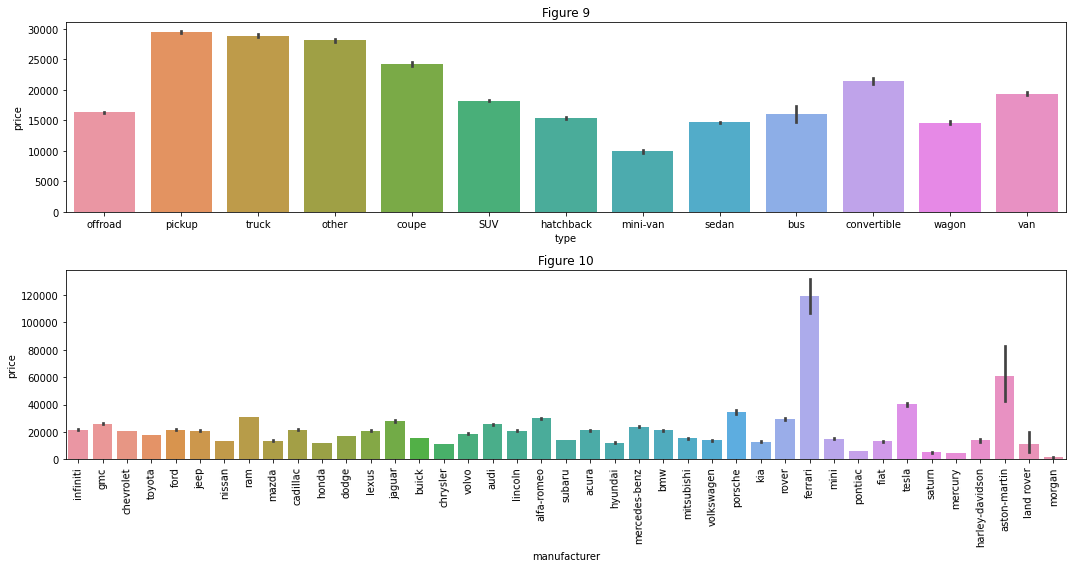

In [ ]:
fig,axs=plt.subplots(nrows=2)
fig.set_size_inches(15,8)
sns.barplot(x='type',y='price',data=df,ax=axs[0])
sns.barplot(x='manufacturer',y='price',data=df,ax=axs[1])
axs[1].set_xticklabels(df.manufacturer.unique(),rotation=91)
axs[0].set_title('Figure 9')
axs[1].set_title('Figure 10')
plt.tight_layout()
plt.savefig('Insight-Figure-9-10.jpg',dpi=600)
plt.show()

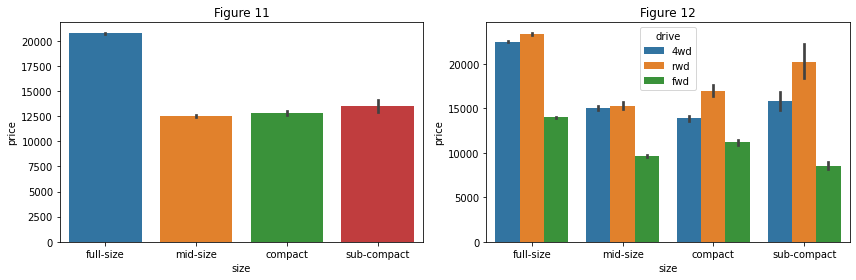

In [ ]:
fig,axs=plt.subplots(ncols=2)
fig.set_size_inches(12,4)
sns.barplot(x='size',y='price',data=df,ax=axs[0])
sns.barplot(x='size',y='price',hue='drive',data=df,ax=axs[1])
axs[0].set_title('Figure 11')
axs[1].set_title('Figure 12')
plt.tight_layout()
plt.savefig('Insight-Figure-11-12.jpg',dpi=600)
plt.show()

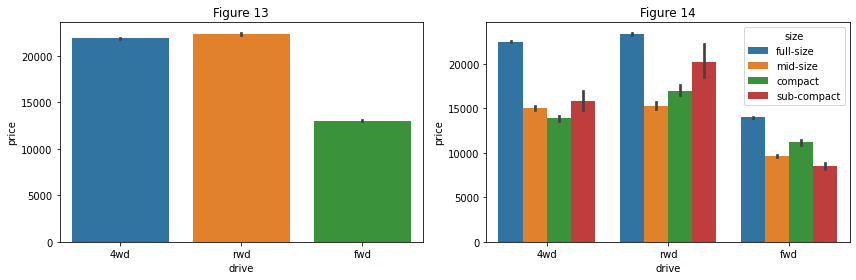

In [ ]:
fig,axs=plt.subplots(ncols=2)
fig.set_size_inches(12,4)
sns.barplot(x='drive',y='price',data=df,ax=axs[0])
sns.barplot(x='drive',y='price',hue='size',data=df,ax=axs[1])
axs[0].set_title('Figure 13')
axs[1].set_title('Figure 14')
plt.tight_layout()
plt.savefig('Insight-Figure-13-14.jpg',dpi=600)
plt.show()

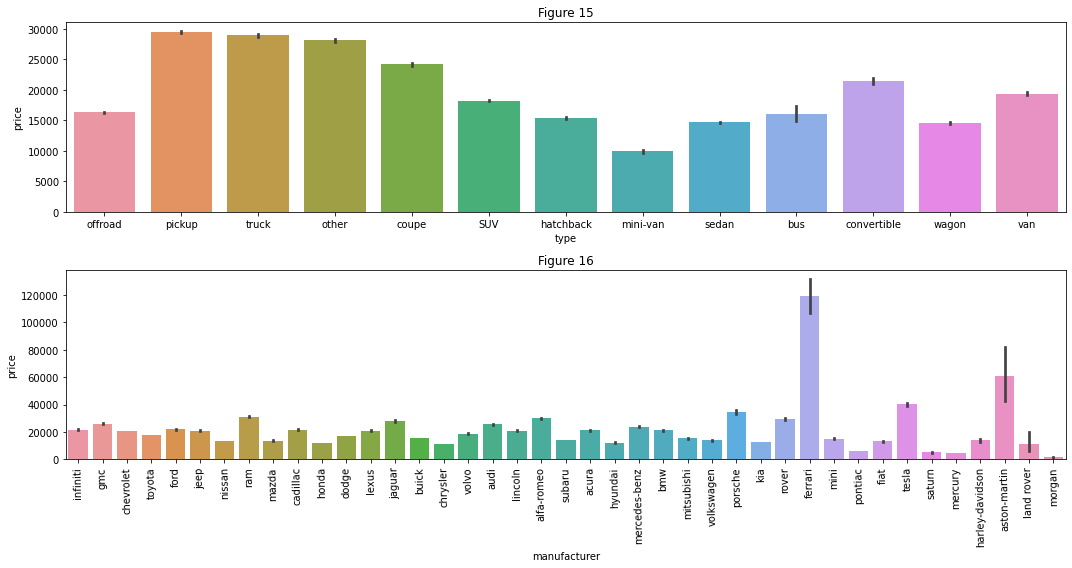

In [ ]:
fig,axs=plt.subplots(nrows=2)
fig.set_size_inches(15,8)
sns.barplot(x='type',y='price',data=df,ax=axs[0])
sns.barplot(x='manufacturer',y='price',data=df,ax=axs[1])
axs[1].set_xticklabels(df.manufacturer.unique(),rotation=91)
axs[0].set_title('Figure 15')
axs[1].set_title('Figure 16')
plt.tight_layout()
plt.savefig('Insight-Figure-15-16.jpg',dpi=600)

plt.show()

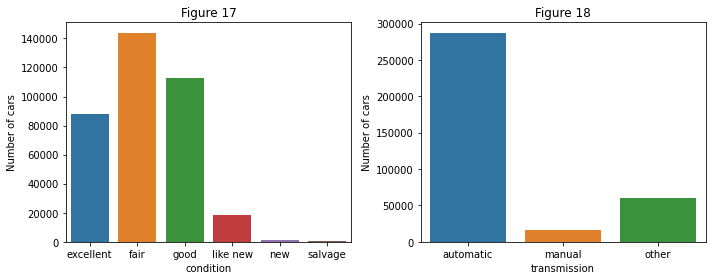

In [ ]:
fig,axs=plt.subplots(ncols=2)
fig.set_size_inches(10,4)
sns.barplot(df.groupby('condition').count()['price'].index,df.groupby('condition').count()['price'].values,ax=axs[0])
sns.barplot(df.groupby('transmission').count()['price'].index,df.groupby('transmission').count()['price'].values,ax=axs[1])
axs[0].set_ylabel('Number of cars')
axs[0].set_title('Figure 17')
axs[1].set_ylabel('Number of cars')
axs[1].set_title('Figure 18')
plt.tight_layout()
plt.savefig('Insight-Figure-17-18.jpg',dpi=600)

plt.show()

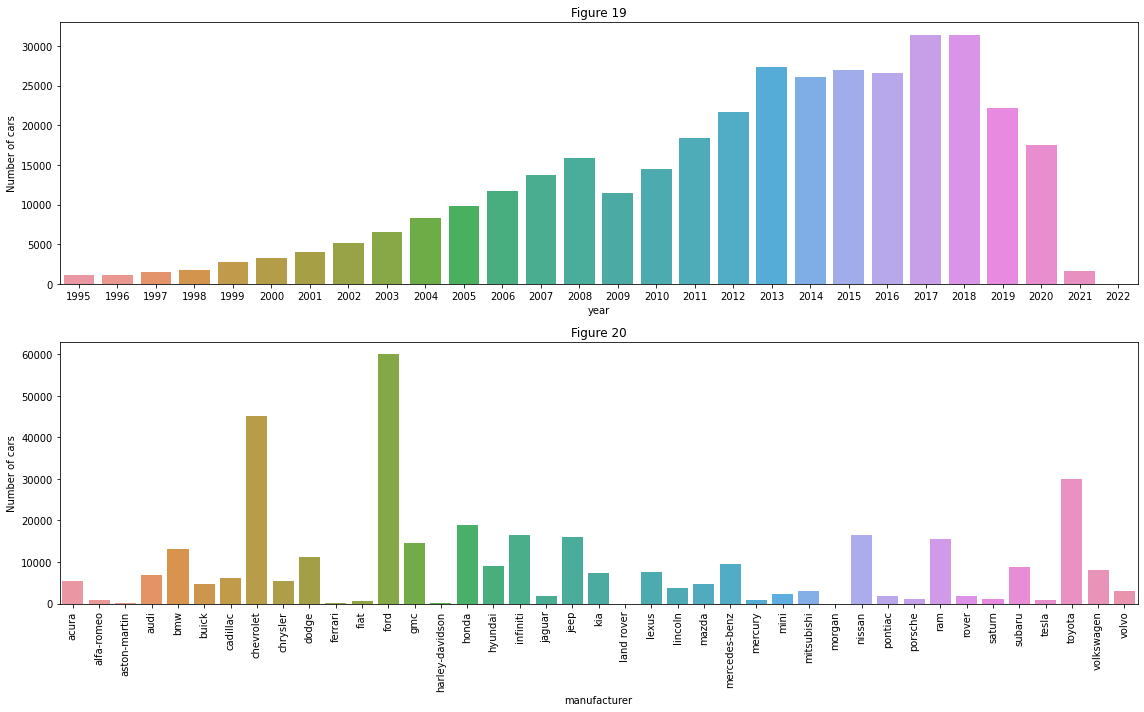

In [ ]:
fig,axs=plt.subplots(nrows=2)
fig.set_size_inches(16,10)
sns.barplot(df.groupby('year').count()['price'].index,df.groupby('year').count()['price'].values,ax=axs[0])
sns.barplot(df.groupby('manufacturer').count()['price'].index,df.groupby('manufacturer').count()['price'].values,ax=axs[1])
axs[0].set_ylabel('Number of cars')
axs[0].set_title('Figure 19')
axs[1].set_ylabel('Number of cars')
axs[1].set_title('Figure 20')
axs[1].set_xticklabels(df.groupby('manufacturer').count()['price'].index,rotation=90)
plt.tight_layout()
plt.savefig('Insight-Figure-19-20.jpg',dpi=600)

plt.show()

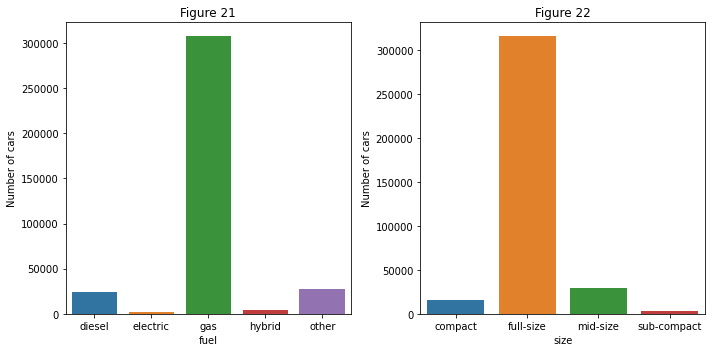

In [ ]:
fig,axs=plt.subplots(ncols=2)
fig.set_size_inches(10,5)
sns.barplot(df.groupby('fuel').count()['price'].index,df.groupby('fuel').count()['price'].values,ax=axs[0])
sns.barplot(df.groupby('size').count()['price'].index,df.groupby('size').count()['price'].values,ax=axs[1])
axs[0].set_ylabel('Number of cars')
axs[0].set_title('Figure 21')
axs[1].set_ylabel('Number of cars')
axs[1].set_title('Figure 22')
plt.tight_layout()
plt.savefig('Insight-Figure-21-22.jpg',dpi=600)

plt.show()

#all ml models

In [ ]:
import pandas as pd
import numpy as np
import time
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt

#libraries for preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

#libraries for evaluation
from sklearn.metrics import mean_squared_log_error,r2_score,mean_squared_error
from sklearn.model_selection import train_test_split


#libraries for models
from sklearn.linear_model import LinearRegression

from sklearn.linear_model import Ridge
from sklearn.linear_model import LassoCV,RidgeCV
from yellowbrick.regressor import AlphaSelection

from sklearn.linear_model import Lasso

from sklearn.neighbors import KNeighborsRegressor

from sklearn.ensemble import RandomForestRegressor

from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

from sklearn.ensemble import AdaBoostRegressor

import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Loading Dataframe

df=pd.read_csv("/content/drive/MyDrive/vehiclesFinal.csv")
#df=pd.read_csv("../input/usedcarpriceprediction/vehiclesFinal.csv")
#df=df.drop('Unnamed: 0',axis=1)
df=df.drop('id',axis=1)

"""df=df.drop('lat',axis=1)
df=df.drop('long',axis=1)
df=df.drop('region',axis=1)"""

df2=df.copy()
df.head()

,region,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,lat,long,price
0,prescott,2009.0,infiniti,g series,fair,5 cylinders,gas,167000.0,clean,automatic,4wd,full-size,offroad,grey,40.4109,-74.238,6000
1,fayetteville,2009.0,infiniti,g series,fair,5 cylinders,gas,167000.0,clean,automatic,4wd,full-size,offroad,grey,40.4109,-74.238,11900
2,florida keys,2009.0,infiniti,g series,fair,5 cylinders,gas,167000.0,clean,automatic,4wd,full-size,offroad,grey,40.4109,-74.238,21000
3,worcester / central MA,2009.0,infiniti,g series,fair,5 cylinders,gas,167000.0,clean,automatic,4wd,full-size,offroad,grey,40.4109,-74.238,1500
4,greensboro,2009.0,infiniti,g series,fair,5 cylinders,gas,167000.0,clean,automatic,4wd,full-size,offroad,grey,40.4109,-74.238,4900


In [ ]:
#defining numerical and categorical values

num_col=['year','odometer','long','lat']
cat_cols=['region','manufacturer','model','condition','cylinders','fuel','title_status','transmission','drive','size','type','paint_color']

In [ ]:
le=preprocessing.LabelEncoder()
df[cat_cols]=df[cat_cols].apply(le.fit_transform)

In [ ]:
df.head(2)

,region,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,lat,long,price
0,128,2009.0,17,8396,1,4,2,167000.0,0,0,0,1,6,5,40.4109,-74.238,6000.0
1,49,2009.0,17,8396,1,4,2,167000.0,0,0,0,1,6,5,40.4109,-74.238,11900.0


In [ ]:
#scaling numerical data

norm = StandardScaler()
df['price'] = np.log(df['price'])
df['odometer'] = norm.fit_transform(np.array(df['odometer']).reshape(-1,1))
df['year'] = norm.fit_transform(np.array(df['year']).reshape(-1,1))
df['model'] = norm.fit_transform(np.array(df['model']).reshape(-1,1))

#scaling target variable
q1,q3=(df['price'].quantile([0.25,0.75]))
o1=q1-1.5*(q3-q1)
o2=q3+1.5*(q3-q1)
df=df[(df.price>=o1) & (df.price<=o2)]

df['region'] = norm.fit_transform(np.array(df['region']).reshape(-1,1))
df['lat'] = norm.fit_transform(np.array(df['lat']).reshape(-1,1))
df['long'] = norm.fit_transform(np.array(df['long']).reshape(-1,1))

In [ ]:
df.head(2)

,region,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,lat,long,price
0,0.702951,-0.637576,17,-0.025,1,4,2,1.23055,0,0,0,1,6,5,0.324538,1.10676,8.699515
1,-0.751792,-0.637576,17,-0.025,1,4,2,1.23055,0,0,0,1,6,5,0.324538,1.10676,9.384294


In [ ]:
#function to split dataset int training and test
def trainingData(df,n):
    X = df.iloc[:,n]
    y = df.iloc[:,-1:].values.T
    y=y[0]
    X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.9,test_size=0.1,random_state=0)
    return (X_train,X_test,y_train,y_test)

X_train,X_test,y_train,y_test=trainingData(df,list(range(len(list(df.columns))-1)))

In [ ]:
#some of models will predict neg values so this function will remove that values
def remove_neg(y_test,y_pred):
    ind=[index for index in range(len(y_pred)) if(y_pred[index]>0)]
    y_pred=y_pred[ind]
    y_test=y_test[ind]
    y_pred[y_pred<0]
    return (y_test,y_pred)

#function for evaluation of model
def result(y_test,y_pred):
    r=[]
    r.append(mean_squared_log_error(y_test, y_pred))
    r.append(np.sqrt(r[0]))
    r.append(r2_score(y_test,y_pred))
    r.append(round(r2_score(y_test,y_pred)*100,4))
    return (r)

#dataframe that store the performance of each model
accu=pd.DataFrame(index=['MSLE', 'Root MSLE', 'R2 Score','Accuracy(%)'])    

# 3) Model Implementation
### 1)Linear Regression
### 2)Ridge Regression
### 3)Lasso Regression
### 4)K-Neighbors Regressor
### 5)Random Forest Regressor
### 6)Adaboost Regressor
### 7)XGBoost

#Linear Regression

In [ ]:
#fitting model
LR=LinearRegression()
LR.fit(X_train,y_train)
y_pred=LR.predict(X_test)

In [ ]:
#calculating error/accuracy
y_test_1,y_pred_1=remove_neg(y_test,y_pred)
r1_lr=result(y_test_1,y_pred_1)
print('Coefficients: \n', LR.coef_)
print("MSLE : {}".format(r1_lr[0]))
print("Root MSLE : {}".format(r1_lr[1]))
print("R2 Score : {} or {}%".format(r1_lr[2],r1_lr[3]))
accu['Linear Regression']=r1_lr

Coefficients: 
 [-1.24709637e-03  4.27266455e-01 -7.99177015e-04 -2.33672063e-03
 -2.32170484e-02  2.01195707e-01 -1.53811941e-01 -2.45278135e-01
 -9.10131864e-02  7.07133890e-02 -8.60482387e-02 -3.46398674e-02
  2.35738510e-03  4.75820330e-03 -3.31307768e-04 -6.82922390e-02]
MSLE : 0.0024059817621410197
Root MSLE : 0.04905080796624067
R2 Score : 0.6264868420899763 or 62.6487%


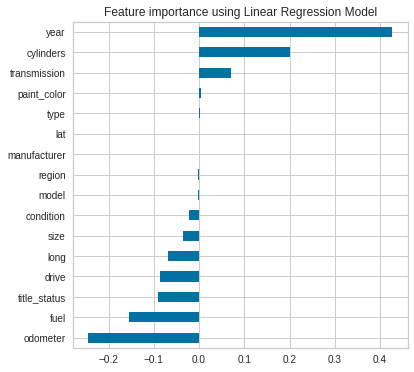

In [ ]:
#Ploting feature importance graph

coef = pd.Series(LR.coef_, index = X_train.columns)
imp_coef = coef.sort_values()
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Linear Regression Model")
plt.savefig('Linear-Regression-Feature-Importance.jpg')
plt.show()

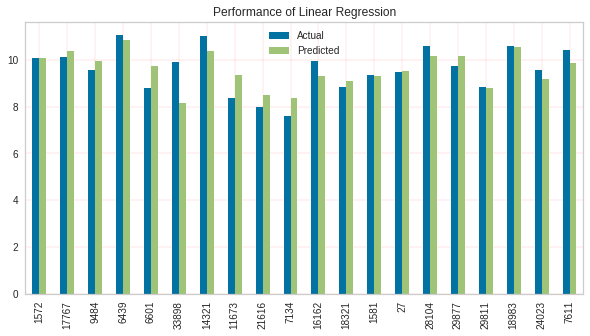

In [ ]:
#Visualization of true value and predicted

df_check = pd.DataFrame({'Actual': y_test_1, 'Predicted': y_pred_1})
df_check = df_check.sample(20)
df_check.plot(kind='bar',figsize=(10,5))
plt.grid(which='major', linestyle='-', linewidth='0.1', color='Red')
plt.title('Performance of Linear Regression')
plt.savefig('Linear-Regression-Performance')
plt.show()

#ridge regression



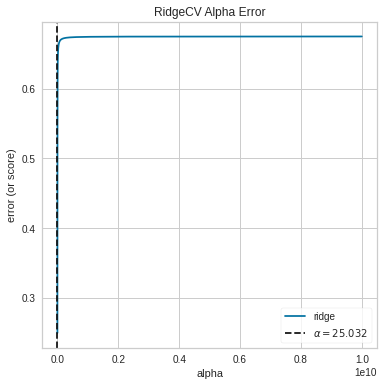

In [ ]:
#predicting value of alpha

alphas = 10**np.linspace(10,-2,400)
model = RidgeCV(alphas=alphas)
visualizer = AlphaSelection(model)
visualizer.fit(X_train,y_train)
visualizer.show()

In [ ]:
#model object and fitting model
RR=Ridge(alpha=25.032,solver='auto')
RR.fit(X_train,y_train)
y_pred=RR.predict(X_test)

In [ ]:
#model evaluation

y_test_2,y_pred_2=remove_neg(y_test,y_pred)
r2_ridge=result(y_test_2,y_pred_2)
print("MSLE : {}".format(r2_ridge[0]))
print("Root MSLE : {}".format(r2_ridge[1]))
print("R2 Score : {} or {}%".format(r2_ridge[2],r2_ridge[3]))
accu['Ridge Regression']=r2_ridge

MSLE : 0.0024059813834220577
Root MSLE : 0.049050804105764234
R2 Score : 0.6264869081394597 or 62.6487%


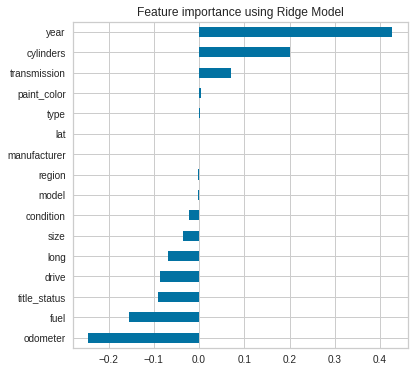

In [ ]:
#Visualization of Feature Importance

coef = pd.Series(RR.coef_, index = X_train.columns)
imp_coef = coef.sort_values()
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Ridge Model")
plt.savefig('Ridge-Regression-Feature-Importance.jpg')
plt.show()

#lasso regression

In [ ]:
#model object and fitting it
lasso=Lasso(alpha=0.0001)
lasso.fit(X_train,y_train)
y_pred=lasso.predict(X_test)

In [ ]:
#model evaluation
y_test_3,y_pred_3=remove_neg(y_test,y_pred)
r3_lasso=result(y_test_3,y_pred_3)
print("MSLE : {}".format(r3_lasso[0]))
print("Root MSLE : {}".format(r3_lasso[1]))
print("R2 Score : {} or {}%".format(r3_lasso[2],r3_lasso[3]))
accu['Lasso Regression']=r3_lasso

MSLE : 0.0024059781790472384
Root MSLE : 0.04905077144191759
R2 Score : 0.6264906747912373 or 62.6491%


#KNN

In [ ]:
#estimating MSLE for k=1-9
R_MSLE=[]
for i in range(1,10):
    KNN=KNeighborsRegressor(n_neighbors=i)
    KNN.fit(X_train,y_train)
    y_pred=KNN.predict(X_test)
    error=np.sqrt(mean_squared_log_error(y_test, y_pred))
    R_MSLE.append(error)
    print("K =",i," , Root MSLE =",error)

K = 1  , Root MSLE = 0.03809067665803172
K = 2  , Root MSLE = 0.03551456269233081
K = 3  , Root MSLE = 0.03495170650040267
K = 4  , Root MSLE = 0.03494909114261161
K = 5  , Root MSLE = 0.03507405473596931
K = 6  , Root MSLE = 0.035255633423864244
K = 7  , Root MSLE = 0.03542406969538101
K = 8  , Root MSLE = 0.03563850934456502
K = 9  , Root MSLE = 0.03587181875044244


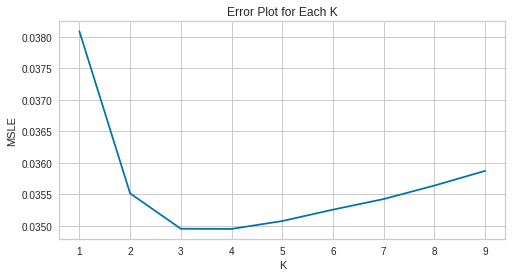

In [ ]:
#plotting error

curve = pd.DataFrame(R_MSLE) #elbow curve 
plt.figure(figsize=(8,4))
plt.xticks(list(range(1,10)), list(range(1,10)), rotation='horizontal')
plt.plot(list(range(1,10)),R_MSLE)
plt.xlabel('K')
plt.ylabel('MSLE')
plt.title('Error Plot for Each K')
plt.savefig('KNN-Error-Plot.jpg')
plt.show()

In [ ]:
#model implementation
KNN=KNeighborsRegressor(n_neighbors=3) 
KNN.fit(X_train,y_train)
y_pred=KNN.predict(X_test)

In [ ]:
#model evaluation
r4_knn=result(y_test,y_pred)
print("MSLE : {}".format(r4_knn[0]))
print("Root MSLE : {}".format(r4_knn[1]))
print("R2 Score : {} or {}%".format(r4_knn[2],r4_knn[3]))
accu['KNN']=r4_knn

MSLE : 0.0012216217872902905
Root MSLE : 0.03495170650040267
R2 Score : 0.8182644342718339 or 81.8264%


In [ ]:
accu.to_csv('errors.csv')

In [ ]:
RFR = RandomForestRegressor(n_estimators=180,random_state=0, min_samples_leaf=1, max_features=0.5, n_jobs=-1, oob_score=True)
RFR.fit(X_train,y_train)
y_pred = RFR.predict(X_test)

In [ ]:
r5_rf=result(y_test,y_pred)
print("MSLE : {}".format(r5_rf[0]))
print("Root MSLE : {}".format(r5_rf[1]))
print("R2 Score : {} or {}%".format(r5_rf[2],r5_rf[3]))
accu['RandomForest Regressor']=r5_rf

MSLE : 0.0006240947093751024
Root MSLE : 0.024981887626340456
R2 Score : 0.9095879585499722 or 90.9588%


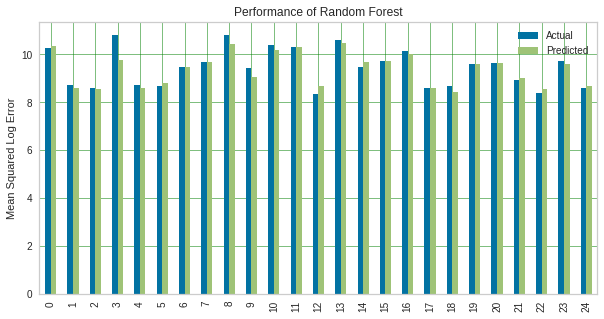

In [ ]:
df_check = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_check = df_check.head(25)
#round(df_check,2)
df_check.plot(kind='bar',figsize=(10,5))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.title('Performance of Random Forest')
plt.ylabel('Mean Squared Log Error')
plt.savefig('Random-Forest-Performance.jpg')
plt.show()

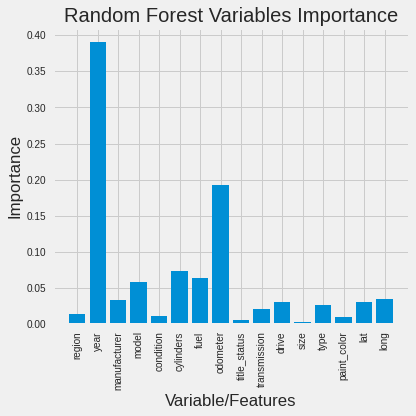

In [ ]:
importances=RFR.feature_importances_
features=X_train.columns

# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.figure(figsize=(6,6))
plt.bar(x_values, importances, orientation = ('vertical'))
# Tick labels for x axis
plt.xticks(x_values, features, rotation=(90))
# Axis labels and title
plt.ylabel('Importance'); 
plt.xlabel('Variable/Features'); 
plt.title('Random Forest Variables Importance')
plt.tight_layout()
plt.savefig('Random-Forest-Variables-Importances.jpg',dpi=600)
plt.show();

#Adaboost

In [ ]:
#model implementation
ABR = AdaBoostRegressor(
    DecisionTreeRegressor(max_depth=24),
    n_estimators=200,learning_rate=0.6
)

ABR.fit(X_train, y_train)
y_pred = ABR.predict(X_test)

In [ ]:
#model evaluation
r7_ab=result(y_test,y_pred)
print("MSLE : {}".format(r7_ab[0]))
print("Root MSLE : {}".format(r7_ab[1]))
print("R2 Score : {} or {}%".format(r7_ab[2],r7_ab[3]))

MSLE : 0.0006579850188453699
Root MSLE : 0.025651218661992842
R2 Score : 0.9030866099173067 or 90.3087%


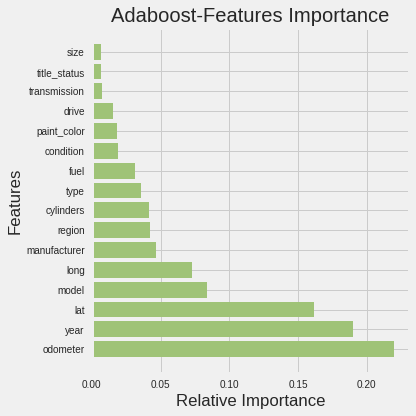

In [ ]:
importances=ABR.feature_importances_
features=X_train.columns

indices = np.argsort(importances)
indices = [x for x in reversed(indices)]
plt.figure(1)
plt.title('Adaboost-Features Importance')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.savefig('Adaboost-Features-Importance2.jpg',dpi=60)
plt.show();

In [ ]:
accu['AdaBoost Regressor']=r7_ab
accu.to_csv('errors.csv')

#xgboost

In [ ]:
param_grid={"learning_rate":[0.20, 0.25, 0.30,0.35,0.4,0.5],
            "n_estimators":[100,120,130,140,150,200],
            "max_depth":range(12,25),
            "booster":["gbtree"]
           }
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
xgb2=xgb.XGBRegressor()
random_cv=RandomizedSearchCV(estimator=xgb2,param_distributions=param_grid,n_iter=5,scoring='roc_auc',n_jobs=-1,cv=5,verbose=3)
warnings.filterwarnings('ignore')
random_cv.fit(X_train,y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[08:33:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(cv=5, estimator=XGBRegressor(), n_iter=5, n_jobs=-1,
                   param_distributions={'booster': ['gbtree'],
                                        'learning_rate': [0.2, 0.25, 0.3, 0.35,
                                                          0.4, 0.5],
                                        'max_depth': range(12, 25),
                                        'n_estimators': [100, 120, 130, 140,
                                                         150, 200]},
                   scoring='roc_auc', verbose=3)

In [ ]:
random_cv.best_estimator_


XGBRegressor(learning_rate=0.35, max_depth=16, n_estimators=150)

In [ ]:
random_cv.best_params_


{'booster': 'gbtree',
 'learning_rate': 0.35,
 'max_depth': 16,
 'n_estimators': 150}

In [ ]:
#model evaluation
y_test_1,y_pred_1=remove_neg(y_test,y_pred)
r8_xg=result(y_test_1,y_pred_1)
print("MSLE : {}".format(r8_xg[0]))
print("Root MSLE : {}".format(r8_xg[1]))
print("R2 Score : {} or {}%".format(r8_xg[2],r8_xg[3]))

MSLE : 0.0005475933717990604
Root MSLE : 0.023400713061765027
R2 Score : 0.9207574807551566 or 92.0757%


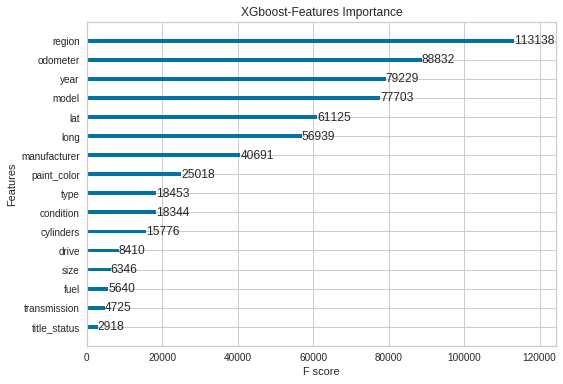

In [ ]:
xgb.plot_importance(xg_reg)
plt.title('XGboost-Features Importance')

plt.rcParams['figure.figsize'] = [5, 5]
plt.tight_layout()
plt.savefig('XGBoost-Features-Importance.jpg')
plt.show();

In [ ]:
accu['XGBoost Regressor']=r8_xg
accu.to_csv('errors.csv')

In [ ]:
accu=pd.read_csv('./errors.csv',index_col=0)
accu

,XGBoost Regressor,Linear Regression,Lasso Regression,KNN,RandomForest Regressor,AdaBoost Regressor
MSLE,0.000548,0.002406,0.002406,0.001222,0.000624,0.000658
Root MSLE,0.023401,0.049051,0.049051,0.034952,0.024982,0.025651
R2 Score,0.920757,0.626487,0.626491,0.818264,0.909588,0.903087
Accuracy(%),92.075700,62.648700,62.649100,81.826400,90.958800,90.308700


In [ ]:
model_accuracy=accu.loc['Accuracy(%)']

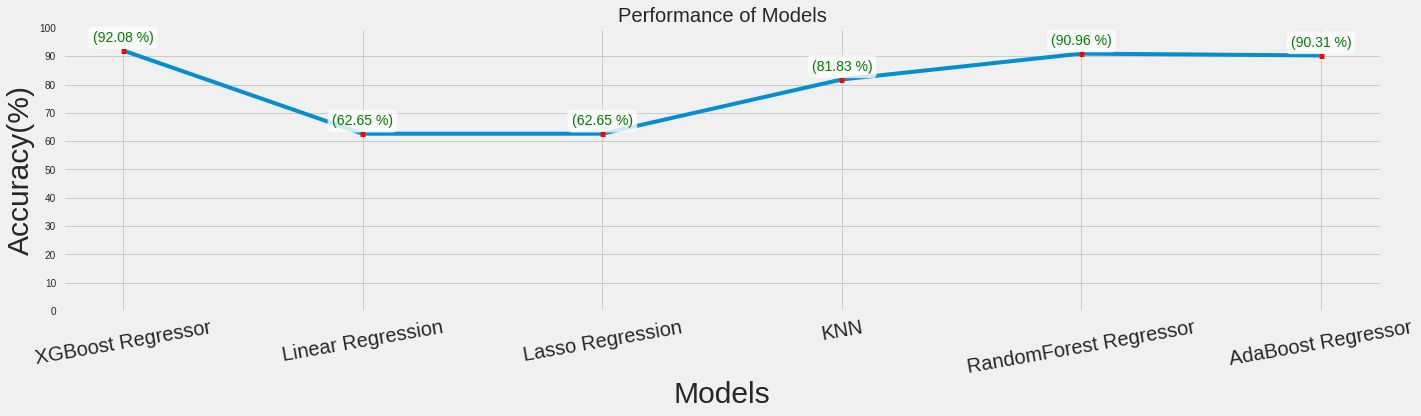

In [ ]:
x=list(range(len(model_accuracy)))
y=list(range(0,101,10))
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
plt.figure(figsize=(20,6))
plt.plot(model_accuracy)
plt.yticks(y)
plt.xticks(fontsize=20)
plt.xticks(rotation = (10))
plt.xlabel("Models",fontsize=30)
plt.ylabel("Accuracy(%)",fontsize=30)
plt.title("Performance of Models")
for a,b in zip(x,y):
    b=model_accuracy[a]
    val="("+str(round(model_accuracy[a],2))+" %)"
    plt.text(a, b+4.5, val,horizontalalignment='center',verticalalignment='center',color='green',bbox=props)
    plt.text(a, b+3.5, '.',horizontalalignment='center',verticalalignment='center',color='red',fontsize=50)
plt.tight_layout()
plt.savefig('Overall-Performance.jpg',dpi=600)
plt.show();

#deployment


In [ ]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_log_error,r2_score,mean_squared_error
from sklearn.model_selection import train_test_split
import xgboost as xgb
import pickle

In [ ]:
df=pd.read_csv('vehiclesFinal.csv')
df.head()

,id,region,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,lat,long,price
0,7222695916,prescott,2009.0,infiniti,g series,fair,5 cylinders,gas,167000.0,clean,automatic,4wd,full-size,offroad,grey,40.4109,-74.238,6000
1,7218891961,fayetteville,2009.0,infiniti,g series,fair,5 cylinders,gas,167000.0,clean,automatic,4wd,full-size,offroad,grey,40.4109,-74.238,11900
2,7221797935,florida keys,2009.0,infiniti,g series,fair,5 cylinders,gas,167000.0,clean,automatic,4wd,full-size,offroad,grey,40.4109,-74.238,21000
3,7222270760,worcester / central MA,2009.0,infiniti,g series,fair,5 cylinders,gas,167000.0,clean,automatic,4wd,full-size,offroad,grey,40.4109,-74.238,1500
4,7210384030,greensboro,2009.0,infiniti,g series,fair,5 cylinders,gas,167000.0,clean,automatic,4wd,full-size,offroad,grey,40.4109,-74.238,4900


In [ ]:
df2=df.copy()
df.drop(['id','title_status','lat','long','model','region'],axis=1,inplace=True)
df.head()

,year,manufacturer,condition,cylinders,fuel,odometer,transmission,drive,size,type,paint_color,price
0,2009.0,infiniti,fair,5 cylinders,gas,167000.0,automatic,4wd,full-size,offroad,grey,6000
1,2009.0,infiniti,fair,5 cylinders,gas,167000.0,automatic,4wd,full-size,offroad,grey,11900
2,2009.0,infiniti,fair,5 cylinders,gas,167000.0,automatic,4wd,full-size,offroad,grey,21000
3,2009.0,infiniti,fair,5 cylinders,gas,167000.0,automatic,4wd,full-size,offroad,grey,1500
4,2009.0,infiniti,fair,5 cylinders,gas,167000.0,automatic,4wd,full-size,offroad,grey,4900


In [ ]:
df2[df2.year==2012.0].head()

,id,region,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,lat,long,price
26,7316343444,auburn,2012.0,gmc,sierra 2500 hd extended cab,good,8 cylinders,gas,68696.0,clean,other,4wd,full-size,pickup,black,32.590000,-85.48000,27990
51,7313406529,auburn,2012.0,honda,odyssey,excellent,6 cylinders,gas,95000.0,clean,automatic,fwd,full-size,mini-van,silver,32.628739,-85.46182,14000
62,7312342811,auburn,2012.0,toyota,tacoma access cab pickup,good,5 cylinders,gas,37725.0,clean,other,4wd,full-size,pickup,white,32.590000,-85.48000,22990
72,7311327726,auburn,2012.0,toyota,tacoma double cab pickup,good,6 cylinders,gas,43182.0,clean,other,4wd,full-size,pickup,white,32.590000,-85.48000,29990
126,7304685502,auburn,2012.0,jeep,wrangler unlimited sport,good,6 cylinders,gas,52172.0,clean,other,4wd,full-size,SUV,black,32.590000,-85.48000,27590


In [ ]:
num_col=['year','odometer']
cat_cols=['manufacturer','condition','cylinders','fuel','transmission','drive','size','type','paint_color']

In [ ]:
temp=[]
for i in cat_cols:
   temp.append(df[i].unique().flatten()) 

In [ ]:
df[cat_cols]=df[cat_cols].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364373 entries, 0 to 364372
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   year          364373 non-null  float64 
 1   manufacturer  364373 non-null  category
 2   condition     364373 non-null  category
 3   cylinders     364373 non-null  category
 4   fuel          364373 non-null  category
 5   odometer      364373 non-null  float64 
 6   transmission  364373 non-null  category
 7   drive         364373 non-null  category
 8   size          364373 non-null  category
 9   type          364373 non-null  category
 10  paint_color   364373 non-null  category
 11  price         364373 non-null  int64   
dtypes: category(9), float64(2), int64(1)
memory usage: 11.5 MB


In [ ]:
columnsValue={}
for col in cat_cols:
    column_labels=list(range(1,len(df[col].unique())+1))
    rep={}
    for i,j in zip(column_labels,df[col].unique()):
        rep[j]=i
    columnsValue[col]=list(df[col].unique())
    df[col].replace(rep,inplace=True)

In [ ]:
df.head()

,year,manufacturer,condition,cylinders,fuel,odometer,transmission,drive,size,type,paint_color,price
0,2009.0,1,1,1,1,167000.0,1,1,1,1,1,6000
1,2009.0,1,1,1,1,167000.0,1,1,1,1,1,11900
2,2009.0,1,1,1,1,167000.0,1,1,1,1,1,21000
3,2009.0,1,1,1,1,167000.0,1,1,1,1,1,1500
4,2009.0,1,1,1,1,167000.0,1,1,1,1,1,4900


In [ ]:
norm = StandardScaler()

norm.fit(df[['year','odometer']])
standardvalues=norm.transform(df[['year','odometer']])

df['year']=standardvalues[:,:1].flatten()
df['odometer']=standardvalues[:,1:].flatten()

pickle.dump(norm, open('StandardScaler.sav', 'wb'))

df['price'] = np.log(df['price'])
#scaling target variable
q1,q3=(df['price'].quantile([0.25,0.75]))
o1=q1-1.5*(q3-q1)
o2=q3+1.5*(q3-q1)
df=df[(df.price>=o1) & (df.price<=o2)]

In [ ]:
df.head()

,year,manufacturer,condition,cylinders,fuel,odometer,transmission,drive,size,type,paint_color,price
0,-0.637576,1,1,1,1,1.23055,1,1,1,1,1,8.699515
1,-0.637576,1,1,1,1,1.23055,1,1,1,1,1,9.384294
2,-0.637576,1,1,1,1,1.23055,1,1,1,1,1,9.952278
3,-0.637576,1,1,1,1,1.23055,1,1,1,1,1,7.313220
4,-0.637576,1,1,1,1,1.23055,1,1,1,1,1,8.496990


In [ ]:
X=df.iloc[:,:-1]
y=df['price']

xg_reg2 = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate = 0.38,
                max_depth = 24, alpha = 5, n_estimators = 200)
xg_reg2.fit(X,y)
pickle.dump(xg_reg2, open('XGBoostDeploy.sav', 'wb'))

In [ ]:
standardscaler= pickle.load(open('StandardScaler.sav', 'rb'))
mymodel = pickle.load(open('XGBoostDeploy.sav', 'rb'))

In [ ]:
df.sample(2)

,year,manufacturer,condition,cylinders,fuel,odometer,transmission,drive,size,type,paint_color,price
324854,1.364311,26,1,1,1,-1.246880,1,3,1,6,7,9.841346
221990,0.272373,22,2,1,1,-1.199227,2,3,1,9,2,9.882775


In [ ]:
df2.iloc[107333]

id                     7309987604
region               northwest GA
year                         2006
manufacturer        mercedes-benz
model           benz slk roadster
condition               excellent
cylinders             6 cylinders
fuel                          gas
odometer                   143223
title_status                clean
transmission            automatic
drive                         rwd
size                    full-size
type                  convertible
paint_color                silver
lat                       34.2507
long                     -85.1465
price                        8800
Name: 107333, dtype: object

In [ ]:
year_odometer=pd.DataFrame(data=[[2020.0,6052]],columns=['year','odometer'])
x=standardscaler.transform(year_odometer[['year','odometer']]).flatten()

In [ ]:
#get col uncoded value
df2.manufacturer.unique()[8-1]

'ram'

In [ ]:
test=pd.DataFrame(data=[[x[0],8,3,1,1,x[1],1,3,1,2,1]],columns=X.columns)
test

,year,manufacturer,condition,cylinders,fuel,odometer,transmission,drive,size,type,paint_color
0,1.364311,8,3,1,1,-1.403275,1,3,1,2,1


In [ ]:
t=[1,8,x[0],1,1,1,1,3,3,2,x[1]]
t

[1, 8, 1.3643111436495816, 1, 1, 1, 1, 3, 3, 2, -1.403275360426239]

In [ ]:
pred=mymodel.predict(test)
price=np.exp(pred[0])
print(price)

28617.836
